### Consensus Problem - *Networked* Active Inference

**Problem description**

In the Consensus problem, a group of agents are connected in a network, and each agent has an initial value. The goal is for the agents to reach a consensus on a common value, despite the presence of noise or uncertainty in the network. The agents can perform local communication and update their own value based on the values of their neighbors.

In [1]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import pymdp

Cases:
|Cases|Description| Dimensionality of constructing single agent|
|-|-|-|
|Trivial|1 agent, immediate solution|1|
|Simple 2-agent| 2 agents, 4 states (and obs), 2 affordances|4|
|General 2-agent| 2 agents, X states (and obs), X affordances| X|

## 2-agent Consensus Problem

In [2]:
obs = [4] # 00, 01, 10, 11
num_obs_modalities = len(obs)

hidden_states = [2, 2]
num_hidden_state_factors = len(hidden_states)

actions = [0, 1]
num_actions_0 = 2
num_actions_1 = 1 # I do not control the state of the other agent

num_controls = [2, 1]

## A matrix

In [3]:
from pymdp import utils

In [4]:
A = pymdp.utils.obj_array(num_obs_modalities)

In [5]:
A_0 = np.zeros( (obs[0], hidden_states[0], hidden_states[1]) )

In [6]:
# A_0 -> perceiving my own state
# A_0[given one of two observations, my state, the other agent's state] = probability of being in those states
A_0[0, 0, 0] = 1
A_0[1, 0, 1] = 1
A_0[2, 1, 0] = 1
A_0[3, 1, 1] = 1

In [73]:
A_0[:, 1, 0]

array([0., 0., 1., 0.])

In [7]:
A[0] = A_0
print(A)

[array([[[1., 0.],
         [0., 0.]],

        [[0., 1.],
         [0., 0.]],

        [[0., 0.],
         [1., 0.]],

        [[0., 0.],
         [0., 1.]]])]


## B matrix

In [8]:
B = utils.obj_array(num_hidden_state_factors)

In [9]:
B_0 = np.zeros( (hidden_states[0], hidden_states[0], num_actions_0) ) 
B_1 = np.zeros( (hidden_states[1], hidden_states[1], num_actions_1) ) 

In [10]:
# B_0 -> transition probabilities of my hidden states given my actions
# B_0[my next state, my current state, my action] = probability of transitioning to next state given current state & action
B_0[0, 0, 0] = 1
B_0[0, 1, 0] = 1
B_0[1, 0, 1] = 1
B_0[1, 1, 1] = 1

In [11]:
B_1[:, :, :] = 0.5 # totally ambiguous, "I have no idea how the other agent changes the states"

In [12]:
B[0] = B_0
B[1] = B_1
print(B)

[array([[[1., 0.],
         [1., 0.]],

        [[0., 1.],
         [0., 1.]]]) array([[[0.5],
                             [0.5]],

                            [[0.5],
                             [0.5]]])]


## C vector

In [13]:
C = utils.obj_array(num_obs_modalities)

In [112]:
# 00 01 10 11
C_0 = np.array([0, 1000, 0, 1000]) # I prefer seeing the states in which both agents have the same state

In [113]:
C[0] = C_0
print(C)

[array([   0, 1000,    0, 1000])]


## D vector

In [114]:
D = utils.obj_array(num_hidden_state_factors)

In [115]:
D_0 = np.array([1.0, 0])
D_1 = np.array([0, 1.0])

In [116]:
D[0] = D_0
D[1] = D_1
print(D)

[array([1., 0.]) array([0., 1.])]


## Agent

In [117]:
from pymdp.agent import Agent

In [118]:
agent = Agent(A=A, B=B, C=C, D=D, num_controls=num_controls)

## Environment

In [119]:
class SingleDeterministic():
    def __init__(self, init_state=[0, 1], fixed_policy=0):
        self.current_state = init_state
        self.init_state = init_state
        self.fixed_policy = fixed_policy
        self.obs = {"[0, 0]": [0], "[0, 1]": [1], "[1, 0]": [2], "[1, 1]": [3]}
        print(f"Starting at state {self.current_state}, fixed second agent with policy {self.fixed_policy}")
        if self.fixed_policy == 0:
            self.s_agent_action = 0
        if self.fixed_policy == 1:
            self.s_agent_action = 1

    def step(self, action):
        if action == 0:
            self.current_state = [0, self.s_agent_action]
        if action == 1:
            self.current_state = [1, self.s_agent_action]
        return self.obs[str(self.current_state)]

    def reset(self):
        self.current_state = self.init_state
        self.fixed_policy = self.fixed_policy
        print("Environment reset")
        return self.obs[str(self.current_state)]

In [120]:
env = SingleDeterministic(init_state=[1, 1], fixed_policy=1)

Starting at state [1, 1], fixed second agent with policy 1


## Active Inference Loop

In [124]:
def plot_beliefs(belief_dist, title_str=""):
    """
    Plot a categorical distribution or belief distribution, stored in the 1-D numpy vector `belief_dist`
    """

    if not np.isclose(belief_dist.sum(), 1.0):
      raise ValueError("Distribution not normalized! Please normalize")

    plt.grid(zorder=0)
    plt.bar(range(belief_dist.shape[0]), belief_dist, color='r', zorder=3)
    plt.xticks(range(belief_dist.shape[0]))
    plt.title(title_str)
    plt.show()

In [125]:
def actinf_loop(agent, env, T=10):
    obs = env.reset()

    for t in range(T):
        print(f"Time: {t}. Agent receives observation: {obs}")
        qs = agent.infer_states(obs)
        plot_beliefs(qs[0], title_str = f"Beliefs about the context at time {t}")
        q_pi, efe = agent.infer_policies()
        chosen_action = agent.sample_action()
        print(f"Agent chose action: {chosen_action}") 
        
        obs = env.step(chosen_action[0])
        print(f"New state: {env.current_state}")

Environment reset
Time: 0. Agent receives observation: [3]


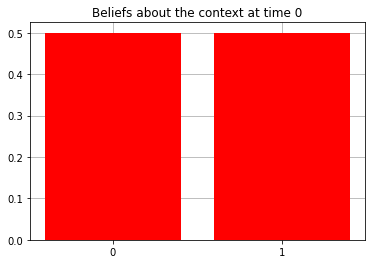

Agent chose action: [0. 0.]
New state: [0, 1]
Time: 1. Agent receives observation: [1]


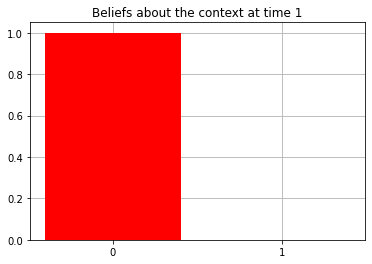

Agent chose action: [0. 0.]
New state: [0, 1]
Time: 2. Agent receives observation: [1]


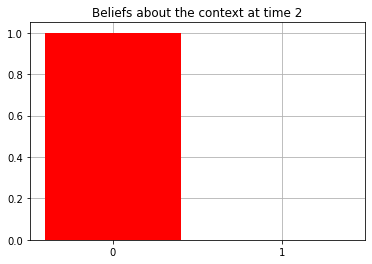

Agent chose action: [0. 0.]
New state: [0, 1]
Time: 3. Agent receives observation: [1]


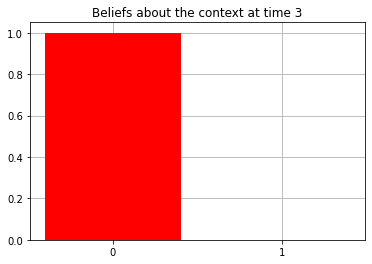

Agent chose action: [0. 0.]
New state: [0, 1]
Time: 4. Agent receives observation: [1]


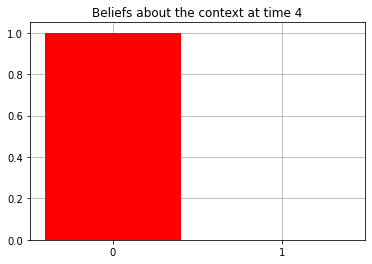

Agent chose action: [0. 0.]
New state: [0, 1]
Time: 5. Agent receives observation: [1]


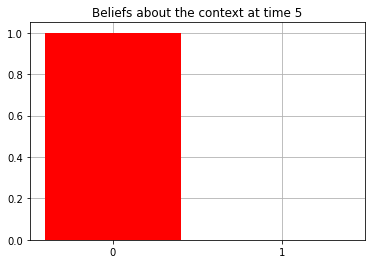

Agent chose action: [0. 0.]
New state: [0, 1]
Time: 6. Agent receives observation: [1]


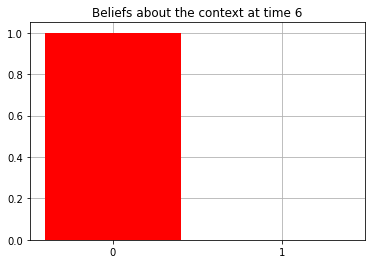

Agent chose action: [0. 0.]
New state: [0, 1]
Time: 7. Agent receives observation: [1]


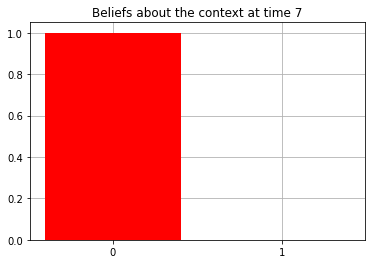

Agent chose action: [0. 0.]
New state: [0, 1]
Time: 8. Agent receives observation: [1]


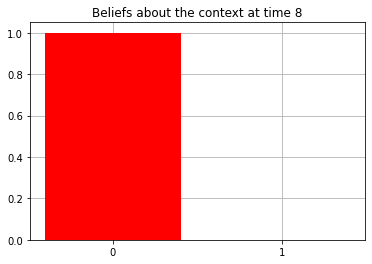

Agent chose action: [0. 0.]
New state: [0, 1]
Time: 9. Agent receives observation: [1]


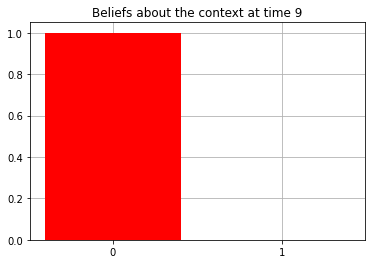

Agent chose action: [0. 0.]
New state: [0, 1]


In [126]:
actinf_loop(agent, env, 10)